In [1]:
from typing import Dict, Text
import tensorflow as tf
import tensorflow_datasets as td
import tensorflow_recommenders as tr
import numpy as np
from pprint import pprint

# tensorflow_datasets -> train, test로 나눠져있음
ratings = td.load('movielens/100k-ratings', split = 'train')
movies = td.load('movielens/100k-movies', split ='train')

Metal device set to: Apple M1


2022-03-30 22:28:48.348168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-30 22:28:48.348261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
len(td.list_builders())

1052

In [2]:
# as_numpy_iterator -> 데이터세트 전체를 numpy로 변환하는 반복문
for x in ratings.take(1).as_numpy_iterator():
    pprint(x)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


2022-03-30 22:28:48.438255: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-30 22:28:48.450557: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [3]:
# as_numpy_iterator -> 데이터세트 전체를 numpy로 변환하는 반복문
for y in movies.take(1).as_numpy_iterator():
    pprint(y)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


2022-03-30 22:28:48.464804: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
ratings = ratings.map(lambda x: {
                                'movie_title': x['movie_title'],
                                'user_id': x['user_id']
                            })
movies = movies.map(lambda x: x['movie_title'])

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)
# train, test split -> 8 : 2

In [5]:
movie_titles = movies.batch(1_000)
# batch 는 당연하게 개수를 맞춰주는 방법
user_ids = ratings.batch(1_000_000).map(lambda x: x['user_id'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
# movie_title는 shape 형태로만 나와서 list로 담고
#tensor 형태를 np.concatenate 배열을 합쳐 unique값만 출력
unique_user_id = np.unique(np.concatenate(list(user_ids)))
# movie_title는 shape 형태로만 나와서 list로 담고
#tensor 형태를 np.concatenate 배열을 합쳐 unique값만 출력
embedding_dimension = 32
# 값이 높을 수록 정확하지만 속도가 느리고 과적합 되기 쉽다.

In [6]:
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_user_id, mask_token=None),
    # stringlookup -> word embedding 과 같이 data-value들이 index로 표현되게 하는 함수
    #mask_token=None -> 마스킹 용어가 추가 되지않게 하는 방법 (1 ~ oov+1)에서 (0~ oov) 으로 인덱싱
    tf.keras.layers.Embedding(len(unique_user_id)+1, embedding_dimension)
    #tf.keras.layers.Embedding(input_dim, output_dim)
    # input_dim -> 최대크기의 정수 , output_dim -> 결과값이 몇개 나올지 
    
])
movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

metrics = tr.metrics.FactorizedTopK(candidates=movies.batch(128).map(movie_model))
# 매트릭 평가를 위해 후보 데이터 세트
task = tr.tasks.Retrieval(metrics=metrics)
#계산된 손실을 반환하는 계층

In [7]:
class tr_model(tr.Model):
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model : tf.keras.Model = movie_model
        self.user_model : tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
    
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features['user_id'])
        movie_embeddings = self.movie_model(features['movie_title'])
        return self.task(user_embeddings, movie_embeddings)

In [8]:
model = tr_model(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
history = model.fit(cached_train, epochs=5)

Epoch 1/5


2022-03-30 22:28:54.634365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:55.074121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:55.087587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 11s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.4333 - factorized_top_k/top_100_categorical_accuracy: 0.4945 - loss: 73818.4531 - regularization_loss: 0.0000e+00 - total_loss: 73818.4531

2022-03-30 22:28:55.472132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:55.487893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 6.1035e-05 - factorized_top_k/top_50_categorical_accuracy: 0.3901 - factorized_top_k/top_100_categorical_accuracy: 0.4985 - loss: 73827.8867 - regularization_loss: 0.0000e+00 - total_loss: 73827.8867 

2022-03-30 22:28:55.749522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:55.763013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/10 [========>.....................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.2207e-04 - factorized_top_k/top_10_categorical_accuracy: 5.6966e-04 - factorized_top_k/top_50_categorical_accuracy: 0.4043 - factorized_top_k/top_100_categorical_accuracy: 0.4786 - loss: 73848.4557 - regularization_loss: 0.0000e+00 - total_loss: 73848.4557

2022-03-30 22:28:56.030133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:56.043093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/10 [===========>..................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 4.2725e-04 - factorized_top_k/top_10_categorical_accuracy: 9.1553e-04 - factorized_top_k/top_50_categorical_accuracy: 0.4146 - factorized_top_k/top_100_categorical_accuracy: 0.4718 - loss: 73864.5957 - regularization_loss: 0.0000e+00 - total_loss: 73864.5957

2022-03-30 22:28:56.293223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:56.306607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 2.4414e-05 - factorized_top_k/top_5_categorical_accuracy: 5.1270e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0012 - factorized_top_k/top_50_categorical_accuracy: 0.4244 - factorized_top_k/top_100_categorical_accuracy: 0.4813 - loss: 73876.1359 - regularization_loss: 0.0000e+00 - total_loss: 73876.1359    

2022-03-30 22:28:56.573723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:56.586648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 2.0345e-05 - factorized_top_k/top_5_categorical_accuracy: 6.1035e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0016 - factorized_top_k/top_50_categorical_accuracy: 0.4403 - factorized_top_k/top_100_categorical_accuracy: 0.4821 - loss: 73877.1419 - regularization_loss: 0.0000e+00 - total_loss: 73877.1419

2022-03-30 22:28:56.870181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:56.883046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 1.7439e-05 - factorized_top_k/top_5_categorical_accuracy: 6.6267e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0018 - factorized_top_k/top_50_categorical_accuracy: 0.4507 - factorized_top_k/top_100_categorical_accuracy: 0.4958 - loss: 73854.7344 - regularization_loss: 0.0000e+00 - total_loss: 73854.7344

2022-03-30 22:28:57.157353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:57.169818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 3.0518e-05 - factorized_top_k/top_5_categorical_accuracy: 7.0190e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0022 - factorized_top_k/top_50_categorical_accuracy: 0.4572 - factorized_top_k/top_100_categorical_accuracy: 0.5110 - loss: 73800.3115 - regularization_loss: 0.0000e+00 - total_loss: 73800.3115

2022-03-30 22:28:57.431071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:57.443877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 4.0690e-05 - factorized_top_k/top_5_categorical_accuracy: 7.4599e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0026 - factorized_top_k/top_50_categorical_accuracy: 0.4717 - factorized_top_k/top_100_categorical_accuracy: 0.5269 - loss: 73716.5260 - regularization_loss: 0.0000e+00 - total_loss: 73716.5260

2022-03-30 22:28:57.731627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:57.743998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 280ms/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 8.7500e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0029 - factorized_top_k/top_50_categorical_accuracy: 0.4770 - factorized_top_k/top_100_categorical_accuracy: 0.5408 - loss: 70118.9304 - regularization_loss: 0.0000e+00 - total_loss: 70118.9304
Epoch 2/5


2022-03-30 22:28:57.985760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:57.999718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0033 - factorized_top_k/top_10_categorical_accuracy: 0.0089 - factorized_top_k/top_50_categorical_accuracy: 0.7142 - factorized_top_k/top_100_categorical_accuracy: 0.6851 - loss: 72259.7891 - regularization_loss: 0.0000e+00 - total_loss: 72259.7891

2022-03-30 22:28:58.279918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:58.294599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 3.0518e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0165 - factorized_top_k/top_50_categorical_accuracy: 0.6913 - factorized_top_k/top_100_categorical_accuracy: 0.7262 - loss: 71564.5000 - regularization_loss: 0.0000e+00 - total_loss: 71564.5000

2022-03-30 22:28:58.576525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:58.591108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/10 [========>.....................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 6.5104e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0098 - factorized_top_k/top_10_categorical_accuracy: 0.0219 - factorized_top_k/top_50_categorical_accuracy: 0.7170 - factorized_top_k/top_100_categorical_accuracy: 0.7406 - loss: 71080.3750 - regularization_loss: 0.0000e+00 - total_loss: 71080.3750

2022-03-30 22:28:58.875137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:58.889656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/10 [===========>..................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 7.3242e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0108 - factorized_top_k/top_10_categorical_accuracy: 0.0245 - factorized_top_k/top_50_categorical_accuracy: 0.7212 - factorized_top_k/top_100_categorical_accuracy: 0.7586 - loss: 70733.9570 - regularization_loss: 0.0000e+00 - total_loss: 70733.9570

2022-03-30 22:28:59.167631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:59.181678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 8.3008e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0121 - factorized_top_k/top_10_categorical_accuracy: 0.0268 - factorized_top_k/top_50_categorical_accuracy: 0.7261 - factorized_top_k/top_100_categorical_accuracy: 0.7657 - loss: 70510.3734 - regularization_loss: 0.0000e+00 - total_loss: 70510.3734

2022-03-30 22:28:59.455006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:59.469593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 8.9518e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0130 - factorized_top_k/top_10_categorical_accuracy: 0.0284 - factorized_top_k/top_50_categorical_accuracy: 0.7365 - factorized_top_k/top_100_categorical_accuracy: 0.7713 - loss: 70307.0951 - regularization_loss: 0.0000e+00 - total_loss: 70307.0951

2022-03-30 22:28:59.761957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:28:59.776906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 9.7656e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0135 - factorized_top_k/top_10_categorical_accuracy: 0.0293 - factorized_top_k/top_50_categorical_accuracy: 0.7505 - factorized_top_k/top_100_categorical_accuracy: 0.7834 - loss: 70171.9498 - regularization_loss: 0.0000e+00 - total_loss: 70171.9498

2022-03-30 22:29:00.053065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:00.067422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0135 - factorized_top_k/top_10_categorical_accuracy: 0.0295 - factorized_top_k/top_50_categorical_accuracy: 0.7558 - factorized_top_k/top_100_categorical_accuracy: 0.7867 - loss: 70042.9482 - regularization_loss: 0.0000e+00 - total_loss: 70042.9482    

2022-03-30 22:29:00.323466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:00.338829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0136 - factorized_top_k/top_10_categorical_accuracy: 0.0296 - factorized_top_k/top_50_categorical_accuracy: 0.7530 - factorized_top_k/top_100_categorical_accuracy: 0.7946 - loss: 69980.4679 - regularization_loss: 0.0000e+00 - total_loss: 69980.4679

2022-03-30 22:29:00.608441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:00.622995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 285ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0134 - factorized_top_k/top_10_categorical_accuracy: 0.0295 - factorized_top_k/top_50_categorical_accuracy: 0.7564 - factorized_top_k/top_100_categorical_accuracy: 0.7955 - loss: 66600.5163 - regularization_loss: 0.0000e+00 - total_loss: 66600.5163
Epoch 3/5


2022-03-30 22:29:00.861933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:00.877230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0146 - factorized_top_k/top_10_categorical_accuracy: 0.0337 - factorized_top_k/top_50_categorical_accuracy: 0.8008 - factorized_top_k/top_100_categorical_accuracy: 0.8601 - loss: 69001.6250 - regularization_loss: 0.0000e+00 - total_loss: 69001.6250

2022-03-30 22:29:01.146404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:01.160920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0018 - factorized_top_k/top_5_categorical_accuracy: 0.0181 - factorized_top_k/top_10_categorical_accuracy: 0.0392 - factorized_top_k/top_50_categorical_accuracy: 0.7792 - factorized_top_k/top_100_categorical_accuracy: 0.8737 - loss: 68561.8203 - regularization_loss: 0.0000e+00 - total_loss: 68561.8203

2022-03-30 22:29:01.417144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:01.432536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/10 [========>.....................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0209 - factorized_top_k/top_10_categorical_accuracy: 0.0428 - factorized_top_k/top_50_categorical_accuracy: 0.7971 - factorized_top_k/top_100_categorical_accuracy: 0.8628 - loss: 68295.9792 - regularization_loss: 0.0000e+00 - total_loss: 68295.9792

2022-03-30 22:29:01.695702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:01.709859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/10 [===========>..................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0216 - factorized_top_k/top_10_categorical_accuracy: 0.0450 - factorized_top_k/top_50_categorical_accuracy: 0.8040 - factorized_top_k/top_100_categorical_accuracy: 0.8689 - loss: 68163.0566 - regularization_loss: 0.0000e+00 - total_loss: 68163.0566

2022-03-30 22:29:02.014155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:02.028714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0223 - factorized_top_k/top_10_categorical_accuracy: 0.0455 - factorized_top_k/top_50_categorical_accuracy: 0.8103 - factorized_top_k/top_100_categorical_accuracy: 0.8630 - loss: 68100.8313 - regularization_loss: 0.0000e+00 - total_loss: 68100.8313

2022-03-30 22:29:02.298135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:02.312510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0221 - factorized_top_k/top_10_categorical_accuracy: 0.0458 - factorized_top_k/top_50_categorical_accuracy: 0.8028 - factorized_top_k/top_100_categorical_accuracy: 0.8604 - loss: 68038.9089 - regularization_loss: 0.0000e+00 - total_loss: 68038.9089

2022-03-30 22:29:02.568273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:02.582977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0221 - factorized_top_k/top_10_categorical_accuracy: 0.0461 - factorized_top_k/top_50_categorical_accuracy: 0.7975 - factorized_top_k/top_100_categorical_accuracy: 0.8666 - loss: 68028.3571 - regularization_loss: 0.0000e+00 - total_loss: 68028.3571

2022-03-30 22:29:02.836182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:02.850042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0218 - factorized_top_k/top_10_categorical_accuracy: 0.0456 - factorized_top_k/top_50_categorical_accuracy: 0.8022 - factorized_top_k/top_100_categorical_accuracy: 0.8721 - loss: 68001.5723 - regularization_loss: 0.0000e+00 - total_loss: 68001.5723

2022-03-30 22:29:03.105608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:03.119968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0214 - factorized_top_k/top_10_categorical_accuracy: 0.0451 - factorized_top_k/top_50_categorical_accuracy: 0.8045 - factorized_top_k/top_100_categorical_accuracy: 0.8754 - loss: 68013.8142 - regularization_loss: 0.0000e+00 - total_loss: 68013.8142

2022-03-30 22:29:03.390106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:03.404788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 278ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0213 - factorized_top_k/top_10_categorical_accuracy: 0.0449 - factorized_top_k/top_50_categorical_accuracy: 0.8051 - factorized_top_k/top_100_categorical_accuracy: 0.8731 - loss: 64797.9744 - regularization_loss: 0.0000e+00 - total_loss: 64797.9744
Epoch 4/5


2022-03-30 22:29:03.656356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:03.670842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0221 - factorized_top_k/top_10_categorical_accuracy: 0.0480 - factorized_top_k/top_50_categorical_accuracy: 0.8667 - factorized_top_k/top_100_categorical_accuracy: 0.8523 - loss: 67487.1797 - regularization_loss: 0.0000e+00 - total_loss: 67487.1797

2022-03-30 22:29:03.923429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:03.939447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0237 - factorized_top_k/top_10_categorical_accuracy: 0.0531 - factorized_top_k/top_50_categorical_accuracy: 0.8293 - factorized_top_k/top_100_categorical_accuracy: 0.8918 - loss: 67138.4258 - regularization_loss: 0.0000e+00 - total_loss: 67138.4258

2022-03-30 22:29:04.211093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:04.231411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/10 [========>.....................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0023 - factorized_top_k/top_5_categorical_accuracy: 0.0260 - factorized_top_k/top_10_categorical_accuracy: 0.0549 - factorized_top_k/top_50_categorical_accuracy: 0.8373 - factorized_top_k/top_100_categorical_accuracy: 0.8827 - loss: 66969.7266 - regularization_loss: 0.0000e+00 - total_loss: 66969.7266

2022-03-30 22:29:04.522079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:04.543856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/10 [===========>..................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0263 - factorized_top_k/top_10_categorical_accuracy: 0.0544 - factorized_top_k/top_50_categorical_accuracy: 0.8270 - factorized_top_k/top_100_categorical_accuracy: 0.8950 - loss: 66938.8281 - regularization_loss: 0.0000e+00 - total_loss: 66938.8281

2022-03-30 22:29:04.832347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:04.857584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0256 - factorized_top_k/top_10_categorical_accuracy: 0.0542 - factorized_top_k/top_50_categorical_accuracy: 0.8414 - factorized_top_k/top_100_categorical_accuracy: 0.9010 - loss: 66940.8625 - regularization_loss: 0.0000e+00 - total_loss: 66940.8625

2022-03-30 22:29:05.151008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:05.178115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0255 - factorized_top_k/top_10_categorical_accuracy: 0.0540 - factorized_top_k/top_50_categorical_accuracy: 0.8559 - factorized_top_k/top_100_categorical_accuracy: 0.9034 - loss: 66944.9727 - regularization_loss: 0.0000e+00 - total_loss: 66944.9727

2022-03-30 22:29:05.491930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:05.520351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0019 - factorized_top_k/top_5_categorical_accuracy: 0.0254 - factorized_top_k/top_10_categorical_accuracy: 0.0539 - factorized_top_k/top_50_categorical_accuracy: 0.8657 - factorized_top_k/top_100_categorical_accuracy: 0.9064 - loss: 66979.2478 - regularization_loss: 0.0000e+00 - total_loss: 66979.2478

2022-03-30 22:29:05.821570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:05.847251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0019 - factorized_top_k/top_5_categorical_accuracy: 0.0252 - factorized_top_k/top_10_categorical_accuracy: 0.0536 - factorized_top_k/top_50_categorical_accuracy: 0.8644 - factorized_top_k/top_100_categorical_accuracy: 0.9093 - loss: 66983.3965 - regularization_loss: 0.0000e+00 - total_loss: 66983.3965

2022-03-30 22:29:06.152912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:06.174393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0253 - factorized_top_k/top_10_categorical_accuracy: 0.0534 - factorized_top_k/top_50_categorical_accuracy: 0.8659 - factorized_top_k/top_100_categorical_accuracy: 0.9068 - loss: 67013.7188 - regularization_loss: 0.0000e+00 - total_loss: 67013.7188

2022-03-30 22:29:06.492516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:06.510013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 310ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0254 - factorized_top_k/top_10_categorical_accuracy: 0.0535 - factorized_top_k/top_50_categorical_accuracy: 0.8654 - factorized_top_k/top_100_categorical_accuracy: 0.9080 - loss: 63860.6875 - regularization_loss: 0.0000e+00 - total_loss: 63860.6875
Epoch 5/5


2022-03-30 22:29:06.731003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:06.745685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0265 - factorized_top_k/top_10_categorical_accuracy: 0.0554 - factorized_top_k/top_50_categorical_accuracy: 0.8917 - factorized_top_k/top_100_categorical_accuracy: 0.8989 - loss: 66759.8750 - regularization_loss: 0.0000e+00 - total_loss: 66759.8750

2022-03-30 22:29:07.031446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:07.044414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/10 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0275 - factorized_top_k/top_10_categorical_accuracy: 0.0592 - factorized_top_k/top_50_categorical_accuracy: 0.9141 - factorized_top_k/top_100_categorical_accuracy: 0.9146 - loss: 66533.0312 - regularization_loss: 0.0000e+00 - total_loss: 66533.0312

2022-03-30 22:29:07.304849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:07.318758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/10 [========>.....................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.0277 - factorized_top_k/top_10_categorical_accuracy: 0.0619 - factorized_top_k/top_50_categorical_accuracy: 0.9104 - factorized_top_k/top_100_categorical_accuracy: 0.9211 - loss: 66416.6771 - regularization_loss: 0.0000e+00 - total_loss: 66416.6771

2022-03-30 22:29:07.576551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:07.589984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 4/10 [===========>..................] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0286 - factorized_top_k/top_10_categorical_accuracy: 0.0623 - factorized_top_k/top_50_categorical_accuracy: 0.9122 - factorized_top_k/top_100_categorical_accuracy: 0.9179 - loss: 66403.1836 - regularization_loss: 0.0000e+00 - total_loss: 66403.1836

2022-03-30 22:29:07.872907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:07.886087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/10 [==============>...............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0022 - factorized_top_k/top_5_categorical_accuracy: 0.0289 - factorized_top_k/top_10_categorical_accuracy: 0.0627 - factorized_top_k/top_50_categorical_accuracy: 0.8902 - factorized_top_k/top_100_categorical_accuracy: 0.9192 - loss: 66421.9484 - regularization_loss: 0.0000e+00 - total_loss: 66421.9484

2022-03-30 22:29:08.161981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:08.175903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/10 [=================>............] - ETA: 1s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0290 - factorized_top_k/top_10_categorical_accuracy: 0.0625 - factorized_top_k/top_50_categorical_accuracy: 0.8858 - factorized_top_k/top_100_categorical_accuracy: 0.9123 - loss: 66416.6523 - regularization_loss: 0.0000e+00 - total_loss: 66416.6523

2022-03-30 22:29:08.431809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:08.445036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 7/10 [====================>.........] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0291 - factorized_top_k/top_10_categorical_accuracy: 0.0625 - factorized_top_k/top_50_categorical_accuracy: 0.8892 - factorized_top_k/top_100_categorical_accuracy: 0.9065 - loss: 66448.3158 - regularization_loss: 0.0000e+00 - total_loss: 66448.3158

2022-03-30 22:29:08.705631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:08.718886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 8/10 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0292 - factorized_top_k/top_10_categorical_accuracy: 0.0626 - factorized_top_k/top_50_categorical_accuracy: 0.8910 - factorized_top_k/top_100_categorical_accuracy: 0.9067 - loss: 66447.7979 - regularization_loss: 0.0000e+00 - total_loss: 66447.7979

2022-03-30 22:29:08.973866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:08.986652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 9/10 [==========================>...] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0291 - factorized_top_k/top_10_categorical_accuracy: 0.0619 - factorized_top_k/top_50_categorical_accuracy: 0.8915 - factorized_top_k/top_100_categorical_accuracy: 0.9087 - loss: 66481.4731 - regularization_loss: 0.0000e+00 - total_loss: 66481.4731

2022-03-30 22:29:09.242185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:09.254921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 271ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0290 - factorized_top_k/top_10_categorical_accuracy: 0.0616 - factorized_top_k/top_50_categorical_accuracy: 0.8926 - factorized_top_k/top_100_categorical_accuracy: 0.9114 - loss: 63359.0788 - regularization_loss: 0.0000e+00 - total_loss: 63359.0788


In [9]:
test_history = model.evaluate(cached_test, return_dict = True)

2022-03-30 22:29:09.604289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 2s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0039 - factorized_top_k/top_50_categorical_accuracy: 0.8499 - factorized_top_k/top_100_categorical_accuracy: 0.8376 - loss: 34163.9336 - regularization_loss: 0.0000e+00 - total_loss: 34163.9336

2022-03-30 22:29:09.973768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:09.985177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:10.167510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/5 [===========>..................] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 1.2207e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0011 - factorized_top_k/top_10_categorical_accuracy: 0.0043 - factorized_top_k/top_50_categorical_accuracy: 0.8351 - factorized_top_k/top_100_categorical_accuracy: 0.8092 - loss: 34151.6719 - regularization_loss: 0.0000e+00 - total_loss: 34151.6719

2022-03-30 22:29:10.180033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:10.352887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:10.365253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/5 [=======================>......] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 1.2207e-04 - factorized_top_k/top_5_categorical_accuracy: 7.3242e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0038 - factorized_top_k/top_50_categorical_accuracy: 0.8271 - factorized_top_k/top_100_categorical_accuracy: 0.8181 - loss: 34158.1357 - regularization_loss: 0.0000e+00 - total_loss: 34158.1357

2022-03-30 22:29:10.544404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:10.555789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-30 22:29:10.737511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 187ms/step - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 7.0000e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0037 - factorized_top_k/top_50_categorical_accuracy: 0.8241 - factorized_top_k/top_100_categorical_accuracy: 0.8138 - loss: 32647.1868 - regularization_loss: 0.0000e+00 - total_loss: 32647.1868


2022-03-30 22:29:10.751888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [10]:
import matplotlib.pyplot as plt

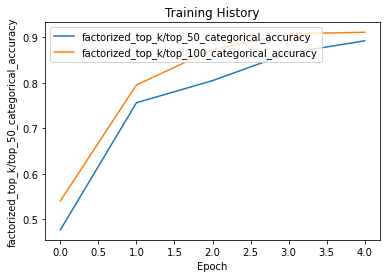

In [21]:
def show_train_history(hisData,first,second): 
    plt.plot(hisData.history[first])
    plt.plot(hisData.history[second])
    plt.title('Training History')
    plt.ylabel(first)
    plt.xlabel('Epoch')
    plt.legend([first, second], loc='upper left')
    plt.show()

show_train_history(history, 'factorized_top_k/top_50_categorical_accuracy', 'factorized_top_k/top_100_categorical_accuracy')

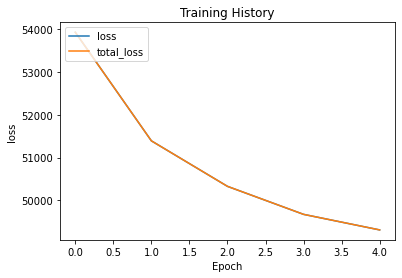

In [22]:
show_train_history(history, 'loss', 'total_loss')

In [13]:
test_history

{'factorized_top_k/top_1_categorical_accuracy': 0.0001500000071246177,
 'factorized_top_k/top_5_categorical_accuracy': 0.0007000000332482159,
 'factorized_top_k/top_10_categorical_accuracy': 0.003650000086054206,
 'factorized_top_k/top_50_categorical_accuracy': 0.8240500688552856,
 'factorized_top_k/top_100_categorical_accuracy': 0.8137500286102295,
 'loss': 29625.2890625,
 'regularization_loss': 0,
 'total_loss': 29625.2890625}